In [1]:
import pandas as pd
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
import os
print(os.listdir())

sns.set_context('talk')
sns.set_style('ticks')

['1501T150917', '1315T040917', 'concatenated_results.csv', 'concatenated_results_150917.csv', '1257T040917', '1432T060917', '1431T060917', '1605T100817', '1453T150917', '1313T030817', 'plot_bayesian_posterior.ipynb', 'concatenated_results_test.csv', '1502T150917', '1454T150917', '1608T100817', '.ipynb_checkpoints', 'DataMerge.ipynb', '1614T100817', '1428T060917', '1455T150917', 'plot_bayesian_tests_posterior.ipynb']


In [2]:
result = pd.DataFrame()
#pfile=os.path.join('1453T150917','parameters.csv')
pfile='concatenated_results_150917.csv'
num_lines = sum(1 for line in open(pfile))-1
df = pd.read_csv(pfile, chunksize=10000, index_col='idx')
for chunk in df:
    #chunk.dropna(axis=0, inplace=True) # Dropping all rows with any NaN value
    chunk.fillna(100000, inplace=True)
    result = result.append(chunk)

print("Number of lines:\t{}".format(num_lines))
print("Number of NaN values:\t{}".format(num_lines-sum(pd.notnull(result['euclidean']))))

Number of lines:	499995
Number of NaN values:	0


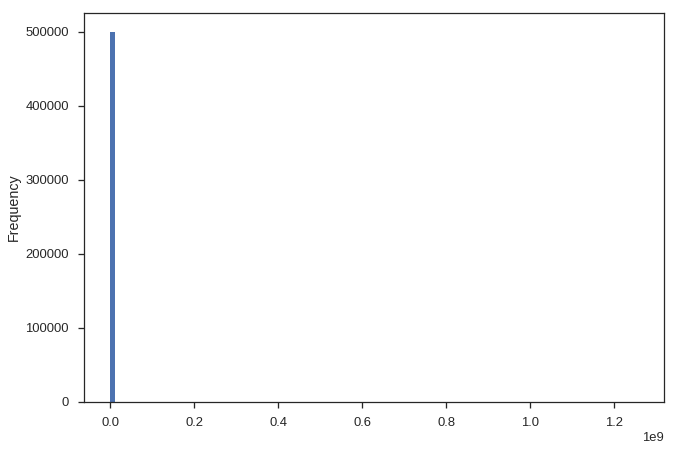

In [3]:
result['euclidean'].plot(kind='hist', bins=100)

Zoom in to lowest 1% of distances to get a better idea of how they are distributed at the bottom end.

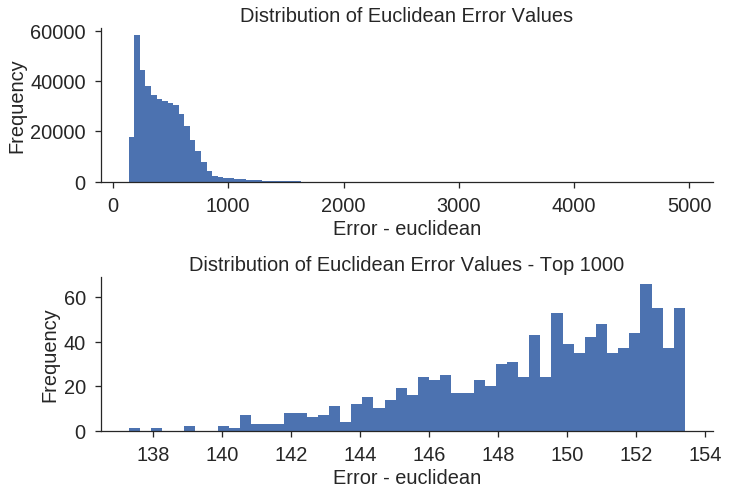

In [4]:
sorted_result = result.sort_values(by='euclidean')
ax = plt.subplot(211, xlabel='Error - euclidean', title='Distribution of Euclidean Error Values')
sorted_result['euclidean'][sorted_result['euclidean']<100000].plot(kind='hist', bins=100, ax=ax)
for item in ([ax.title, ax.xaxis.label, ax.yaxis.label] +
             ax.get_xticklabels() + ax.get_yticklabels()):
    item.set_fontsize(20)
    
ax = plt.subplot(212, xlabel='Error - euclidean', title='Distribution of Euclidean Error Values - Top 1000')

sorted_result['euclidean'][sorted_result['euclidean']<100000].head(1000).plot(kind='hist', bins=50, ax=ax)
for item in ([ax.title, ax.xaxis.label, ax.yaxis.label] +
             ax.get_xticklabels() + ax.get_yticklabels()):
    item.set_fontsize(20)
sns.despine()
plt.tight_layout()

# Obtaining posteriors #
From the current OpenOpt framework, a distance of about 165 has been obtained as a best fit. Adding a small amount on to this to allow for the fact that 165 is not a "truly" best fit - a lower value may be possible and a slightly higher value may be considered a reasonable fit overall.

In [5]:
from math import log10, floor

def round_sig(x, sig=1):
    return round(x, sig-int(floor(log10(abs(x))))-1)

In [6]:
def scatter_dist_plot(params, frac, n_ticks, d=r'euclidean'):
    """
    Inputs:
    =======
    params: list of params to compare pairwise
    frac: fraction of results to consider. Should be given as a percentage i.e. 1=1%, 0.1=0.1%
    n_ticks: number of x-axis ticks
    d: distance measure (str)
    """
    frac_perc = frac/100
    plt.figure()

    sorted_result['Accepted'] = np.zeros(len(sorted_result))
    sorted_result['Accepted'].iloc[:int(num_lines*frac_perc)] = 1
    with sns.plotting_context("talk", font_scale=1.2, rc={"figure.figsize":(12,9)}):
        g = sns.PairGrid(sorted_result, vars=params, hue='Accepted', size=4, diag_sharey=False)
        g.map_diag(sns.kdeplot, lw=3, legend=False)
        g.map_offdiag(plt.scatter)
        g.add_legend()
        for ii, ax in enumerate(g.axes.flat):
            xmax = 1.1*max(sorted_result[params[ii%len(params)]])
            xmin = 0.9*min(sorted_result[params[ii%len(params)]])
            xticks = np.arange(xmin, xmax, round_sig((xmax-xmin)/n_ticks))
            ax.set_xticks(xticks)
            for label in ax.get_xticklabels():
                label.set_rotation(50)
        plt.subplots_adjust(top=0.9)
        plt.suptitle("Parameter distributions - Top {}% based on {} distance".format(frac, d))
        new_labels = [r'Yes', r'No']
        for t, l in zip(g.fig.get_children()[-1].texts, new_labels):
            t.set_text(l)

In [7]:
params=[r'r_t',r'r_0',r'r_m',r'cytox_tot_tis',r'Vol_mit',r'O2_n',r'v_cn',r'sigma_coll']

In [8]:
#for frac in [1,0.1,0.01]:
#    scatter_dist_plot(params, frac, 6, r'euclidean')


# Distributions #
The following plots show the top 0.1% and top 1% of parameters. They are plotted as KDE plots, and histograms of the general distributions is also included.

In [9]:
def kde_plot(params,frac, n_ticks=6, d=r'euclidean'):
    result.sort_values(by=d, inplace=True)
    g = sns.PairGrid(result.iloc[:int(num_lines*(frac/100))], vars=params)
    g.map_diag(plt.hist)
    g.map_offdiag(sns.kdeplot, lw=3, legend=False)
    for ii, ax in enumerate(g.axes.flat):
        for label in ax.get_xticklabels():
            label.set_rotation(50)
        ax.set_ylim(0.8*min(result[params[ii//len(params)]]), 1.2*max(result[params[ii//len(params)]]))
        ax.set_xlim(0.8*min(result[params[ii%len(params)]]), 1.2*max(result[params[ii%len(params)]]))
    plt.subplots_adjust(top=0.9)
    plt.suptitle("Parameter distributions - top {}% based on {}".format(frac, d))

In [10]:
#for f in [1,0.1,0.01]:
#    kde_plot(params, f)

## Resampling ##


In [11]:
from scipy import stats

In [12]:
posterior = {}
for frac in [0.01,0.001,0.0001]:
    d = 'euclidean'
    params = params
    result.sort_values(by=d, inplace=True)
    p = result.iloc[:int(num_lines*frac)][params].as_matrix()
    posterior[frac] = stats.gaussian_kde(p.T).resample(1)

In [13]:
posterior

{0.0001: array([[  1.45550035e-02],
        [  1.17186677e-02],
        [  2.60620035e-02],
        [  6.30911541e-03],
        [  8.68130255e-02],
        [  3.19503883e-02],
        [  3.15919483e+01],
        [  5.66765341e+01]]), 0.001: array([[  1.47487952e-02],
        [  1.12661447e-02],
        [  3.54860117e-02],
        [  5.46114044e-03],
        [  6.61509070e-02],
        [  1.94951758e-02],
        [  3.24843888e+01],
        [  5.73258921e+01]]), 0.01: array([[  1.60170150e-02],
        [  1.19780732e-02],
        [  2.25901582e-02],
        [  3.85119948e-03],
        [  6.70554830e-02],
        [  2.11344987e-02],
        [  3.16931419e+01],
        [  6.92539132e+01]])}

# Run Model #

In [14]:
import sys
sys.path.append('../../..')

In [15]:
from bayescmd.util import findBaseDir

In [16]:
BASEDIR = os.path.abspath(findBaseDir('BayesCMD'))


STARTING AT: /home/buck06191/repos/GitHub/BayesCMD/bayescmd
 Looking for: BayesCMD


In [17]:
os.environ['BASEDIR']='BayesCMD'

In [18]:
from bayescmd.bcmdModel import ModelBCMD

STARTING AT: /home/buck06191/repos/GitHub/BayesCMD/bayescmd
 Looking for: BayesCMD


In [19]:
input_path = os.path.join(BASEDIR,'data','hx01.csv')
openopt_path = os.path.join(BASEDIR,'data','hx01_611.csv')

In [20]:
true_data = pd.read_csv(input_path)
openopt_data = pd.read_csv(openopt_path)

In [21]:
outputs = ['Vmca','CCO']
model_name = 'BS'
inputs = ['Pa_CO2', 'P_a', 'SaO2sup']
times = true_data['t'].as_matrix()

In [22]:
from bayescmd import abc
d0 = abc.import_actual_data(input_path)
input_data = abc.inputParse(d0, inputs)

In [23]:
def run_model(model):
    model.create_initialised_input()
    model.run_from_buffer()
    output = model.output_parse()
    return output


In [50]:
def plot_output(posterior_sample, param_names, plot=True):
    # run model and collect output
    p = dict(zip(param_names, [round_sig(l, sig=3) for i in posterior_sample[1] for l in i]))

    model = ModelBCMD(model_name,
                     inputs=input_data,
                     params=p,
                     times=times,
                     outputs=outputs)
    
    output = run_model(model)
    dist = abc.get_distance(d0,
                            output,
                            outputs,
                            distance='euclidean',
                            zero_flag=[0, 0])
    try:
        out_df = pd.DataFrame(data=output)
    except ValueError as e:
        print("error running for {}".format(posterior_sample[1]))
        raise e
    for k, v in dist.items():
        p[k] = v
    if plot:
        plt.rc('text', usetex=False)
        fig, ax = plt.subplots(2)
        with sns.plotting_context("talk", rc={"figure.figsize":(12,9)}):
            ax[0].plot(times, out_df['CCO'], 'b', label='Bayesian')
            ax[0].plot(times, true_data['CCO'], 'g', label='True')
            ax[0].plot(times, openopt_data['CCO'], 'r', label='openopt')
            t = 'CCO: $Error={CCO:.4f}$'
            p_str = ""
            i = 0
            for k in p.keys():
                if k not in dist.keys():
                    p_str+= "{0}={{{0}}}".format(k)
                    if (i+1)%3==0:
                        p_str+='\n'
                    else:
                        p_str+='    '
                    i+=1
            p_str=p_str.format(**p)
            ax[0].set_title(t.format(**p))
            ax[0].title.set_fontsize(19)
            ax[0].set_xlabel('Time (sec)')
            ax[0].set_ylabel(r'CCO ($\mu M$)')
            for item in ([ax[0].xaxis.label, ax[0].yaxis.label] +
             ax[0].get_xticklabels() + ax[0].get_yticklabels()):
                item.set_fontsize(17)
            
            ax[1].plot(times, out_df['Vmca'], 'b', label='Bayesian')
            ax[1].plot(times, true_data['Vmca'], 'g', label='True')
            ax[1].plot(times, openopt_data['Vmca'], 'r', label='openopt')
            t = 'Vmca: $Error={Vmca:.4f}$'
            ax[1].set_title(t.format(**p))
            ax[1].legend(prop={"size":17},bbox_to_anchor=(1.25, 1.5))
            ax[1].title.set_fontsize(19)
            ax[1].set_xlabel('Time (sec)')
            ax[1].set_ylabel(r'Vmca ($cm\,s^{-1}$)')
            plt.subplots_adjust(top=0.6)
            fig.suptitle("Top {}% of data".format(posterior_sample[0]*100))
            for item in ([ax[1].xaxis.label, ax[1].yaxis.label] +
             ax[1].get_xticklabels() + ax[1].get_yticklabels()):
                item.set_fontsize(17)
            plt.rc('text', usetex=False)
            plt.figtext(0.25,-0.05, p_str)
            fig.tight_layout(rect=[0, 0.03, 1, 0.95])
    return p, output

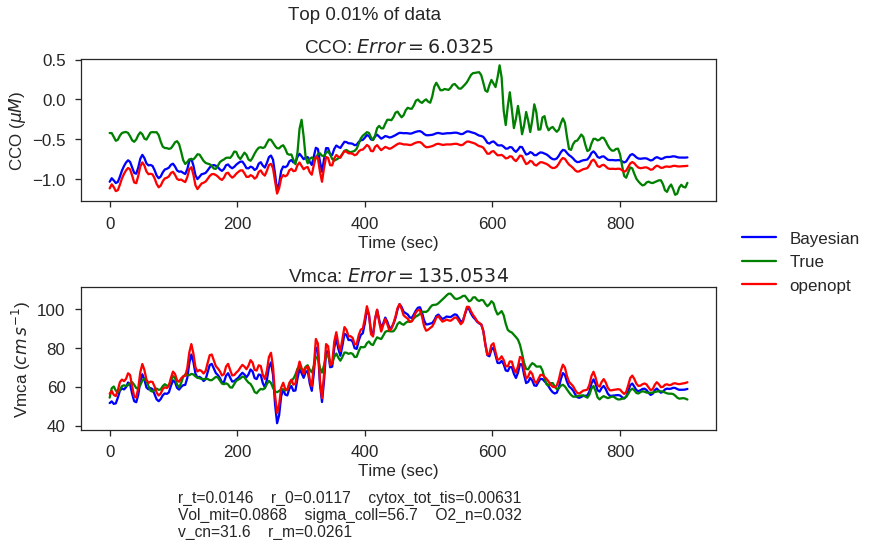

In [51]:
_ = plot_output(list(posterior.items())[0], params)

In [58]:
import matplotlib.lines as mlines

def plot_repeated_outputs(n_repeats, frac):
    """
    inputs
    =======
    frac: Fraction to plot as a percentage
    """
    outputs_list= []
    while len(outputs_list)<n_repeats:
        p = result.iloc[:int(num_lines*(frac/100))][params].as_matrix()
        ps = stats.gaussian_kde(p.T).resample(1)
        try:
            p, o = plot_output((frac/100, ps), params, plot=False)
        except ValueError:
            continue
        #print(p)
        #if p['dist']!=np.nan:
        outputs_list.append((p, o))
        #else:
        #    continue
    av_error = np.nanmean([o[0]['TOTAL'] for o in outputs_list])
    av_CCO_error = np.nanmean([o[0]['CCO'] for o in outputs_list])
    av_Vmca_error = np.nanmean([o[0]['Vmca'] for o in outputs_list])
    CCO_data = [o[1]['CCO'] for o in outputs_list]
    Vmca_data = [o[1]['Vmca'] for o in outputs_list]
    
    with sns.plotting_context("talk", rc={"figure.figsize":(12,9)}):
        fig, ax = plt.subplots(2)
        g = sns.tsplot(data=CCO_data, time=times, estimator=np.nanmean, ax=ax[0])
        true_plot, = ax[0].plot(times, true_data['CCO'], 'g', label='True')
        bayes_line = mlines.Line2D([], [], color=sns.color_palette()[0], label='Bayes')
        ax[0].legend(handles=[bayes_line, true_plot], prop={"size":17})
        ax[0].set_title("CCO: Average Euclidean Distance of {:.4f}".format(av_CCO_error))
        ax[0].set_ylabel(r'CCO ($\mu M$)')
        ax[0].set_xlabel('Time (sec)')
        ax[0].title.set_fontsize(19)
        for item in ([ax[0].xaxis.label, ax[0].yaxis.label] +
         ax[0].get_xticklabels() + ax[0].get_yticklabels()):
            item.set_fontsize(17)
        ax[1].legend(handles=[bayes_line, true_plot], prop={"size":17},bbox_to_anchor=(1.25, 1.5))
        
        g = sns.tsplot(data=Vmca_data, time=times, estimator=np.nanmean, ax=ax[1])
        true_plot, = ax[1].plot(times, true_data['Vmca'], 'g', label='True')
        ax[1].set_title("Vmca: Average Euclidean Distance of {:.4f}".format(av_Vmca_error))
        ax[1].set_ylabel(r'CCO ($\mu M$)')
        ax[1].set_xlabel('Time (sec)')
        ax[1].title.set_fontsize(19)
        for item in ([ax[1].xaxis.label, ax[1].yaxis.label] +
         ax[1].get_xticklabels() + ax[1].get_yticklabels()):
            item.set_fontsize(17)
        fig.tight_layout(rect=[0, 0.03, 1, 0.95])
        fig.suptitle("Simulated output for {} repeats using top {}% of data".format(n_repeats, frac))
    return None

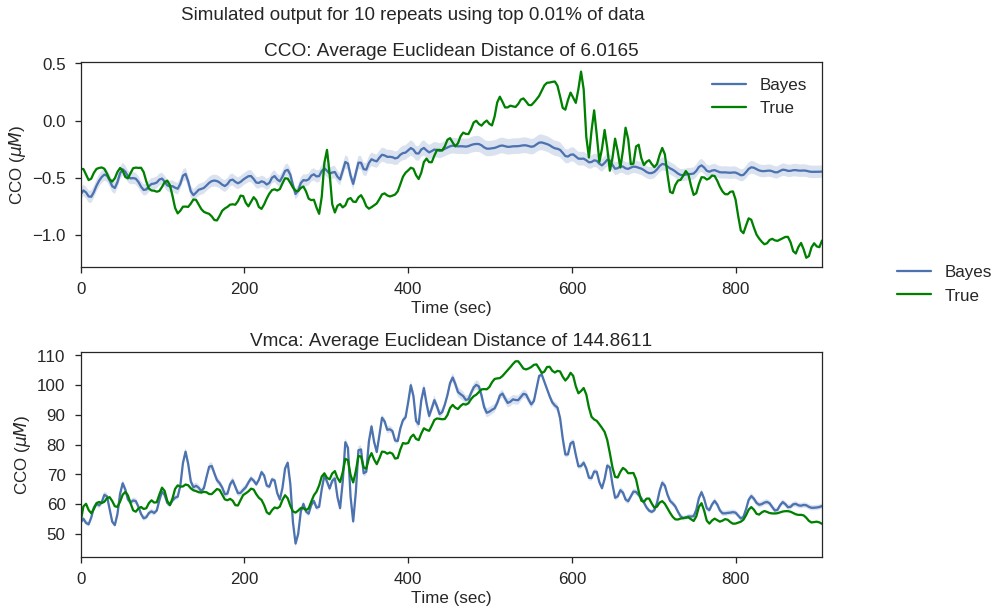

In [59]:
plot_repeated_outputs(100, 0.01)

In [57]:
outputs_list= []
frac = 0.01
for i in range(50):
    p = result.iloc[:int(num_lines*(frac/100))][params].as_matrix()
    ps = stats.gaussian_kde(p.T).resample(1)
    outputs_list.append(plot_output((frac, ps), params, plot=False))


AttributeError: 'float' object has no attribute 'items'

In [ ]:
CCO_data = [o[1]['CCO'] for o in outputs_list]

In [ ]:
Vmca_data = [o[1]['Vmca'] for o in outputs_list]

In [ ]:
ax1 = sns.tsplot(data=CCO_data, time=times, err_style=["ci_band"], ci=[68,95])
ax1.plot(times, true_data['CCO'], 'g', label='True')
ax1.plot(times, openopt_data['CCO'], 'r', label='openopt')

In [ ]:
ax2 = sns.tsplot(data=Vmca_data, time=times, err_style="ci_band", ci=[68,95], estimator=np.nanmean)
ax2.plot(times, openopt_data['Vmca'], 'r', label='openopt')
ax2.plot(times, true_data['Vmca'], 'g', label='True')
ax2.legend()

In [ ]:
ax2 = sns.tsplot(data=CCO_data, time=times, err_style=["unit_traces", "ci_band"], ci=[100], estimator=np.nanmean)

In [ ]:
Vmca_min = np.array(Vmca_data).min(axis=0)
Vmca_max = np.array(Vmca_data).max(axis=0)
Vmca_mean = np.array(Vmca_data).mean(axis=0)

ax = plt.subplot(1,1,1)
ax.plot(times,Vmca_mean, 'k')
ax.fill_between(times, Vmca_min, Vmca_max)

In [ ]:
CCO_min = np.array(CCO_data).min(axis=0)
CCO_max = np.array(CCO_data).max(axis=0)
CCO_mean = np.array(CCO_data).mean(axis=0)

ax = plt.subplot(1,1,1)
ax.plot(times, CCO_mean, 'k')
ax.fill_between(times, CCO_min, CCO_max)

# Plot the KDE #

In [ ]:
rt_range = np.linspace(0.01,0.03,100)
rm_range = np.linspace(0.01, 0.04, 100)
r0_range = np.linspace(0.007, 0.0175, 100)
volmit_range = np.linspace(0.02, 0.12, 100)
cytox_range =  np.linspace(0.0025, 0.009, 100)

ranges = [rt_range, rm_range, r0_range, volmit_range, cytox_range]

In [ ]:
# #import itertools
# #posterior = {}
# #fig, ax = plt.subplots(5,5)
# #for frac in [0.0001,0.001,0.01]:
#     d = 'euclidean'
#     params = ['r_t', 'r_0', 'r_m', 'Vol_mit', 'cytox_tot_tis']
#     result.sort_values(by=d, inplace=True)
#     p = result.iloc[:int(num_lines*frac)][params].as_matrix()
    
#     for r in itertools.combinations(range(5), 2):
#         kernel = stats.gaussian_kde(p[:,r].T)
#         x,y = ranges[r[0]], ranges[r[1]]
#         X, Y = np.meshgrid(x, y)
#         positions = np.vstack([X.ravel(), Y.ravel()])
#         Z = np.reshape(kernel(positions).T, X.shape)
#         plt.figure()
#         plt.imshow(np.rot90(Z), cmap=plt.cm.gist_earth_r,
#                               extent=[x.min(), x.max(), y.min(), y.max()])
#         plt.title("{} vs {}".format(params[r[0]], params[r[1]]))